# Tutorial: GraphRicciCurvature

This is a walk through tutorial of GraphRicciCurvature, and a demonstration of how to apply Ricci curvature for various tasks such as community detection. Please make sure you have the latest package to run this tutorial.

- Try this tutorial with interactive jupyter notebooks:

    - [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/saibalmars/GraphRicciCurvature/master?filepath=notebooks%2Ftutorial.ipynb)
    
    - [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saibalmars/GraphRicciCurvature/blob/master/notebooks/tutorial.ipynb) (Faster, but Google account required.)



## Preparation:
### Load library

In [ ]:
# colab setting
!pip install GraphRicciCurvature
!pip install scikit-learn

# import sys
# sys.path.append("../")


import networkx as nx
import numpy as np
import math

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

In [2]:
import GraphRicciCurvature
print(GraphRicciCurvature.__version__)


0.5.3


### Load sample graph

- First, let's load karate club graph from networkx as an example.
- Ricci curavture and Ricci flow supported weighted graph, but for simplification, let's start from the unweighted graph first.

In [3]:
G = nx.karate_club_graph()
for (n1, n2, d) in G.edges(data=True):
    d.clear()   # remove edge weight 

In [4]:
print(nx.info(G))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


---
## Discrete Ricci curvature
Curvature is a geometric property to describe the local shape of an object. In the graph, an edge with *positive curvature* represents an edge within a cluster, while a *negative curvature* edge tents to be a bridge within clusters.

Currently, there are multiple ways to discretize curvature on graph, in this library, we include two of the most frequently used discrete Ricci curvature:

- **Ollivier-Ricci curvature**: Optimal transportation theory-based curvature. Provide a micro view of curvature for each edge but more computational heavy.
- **Forman-Ricci curvature**: CW complexes based curvature. Provide a macro view of curvature for each edge with super light computation speed.

Notice that while these two curvatures are shown to have a similar trend [[samal]](https://www.nature.com/articles/s41598-018-27001-3), they are defined from different point fo views and should be treated as different property.

### Ollivier-Ricci curvature
- To compute the Ollivier-Ricci curvature of a graph, we can use the class `OllivierRicci` to load the graph and setup the parameter for the curvature computation.


In [5]:
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")

INFO:Edge weight not detected in graph, use "weight" as default edge weight.


- After setup the class `orc`, we can call `compute_ricci_curvature` to start the Ricci curvature computation. The graph in the class with results will be updated.

In [6]:
orc.compute_ricci_curvature()
G_orc = orc.G.copy()  # save an intermediate result

TRACE:Number of nodes: 34
TRACE:Number of edges: 78
TRACE:Start to compute all pair shortest path.
TRACE:0.002834 secs for all pair by NetworKit.
INFO:0.200310 secs for Ricci curvature computation.


- The computed edge Ricci curvature is then stored in the returned networkx graph `G_orc`. Let's check the first five results and plot the histogram of the edge Ricci curvature distributions.
- In most of case, Ollivier-Ricci curvatures are in the range of [-1, 1].
- The Ricci curvature distributions is shown to be different from graph to graph, and can be act as a graph fingerprint or graph kernel.

Karate Club Graph, first 5 edges: 
Ricci curvature of edge (0,1) is 0.111111
Ricci curvature of edge (0,2) is -0.143750
Ricci curvature of edge (0,3) is 0.041667
Ricci curvature of edge (0,4) is -0.114583
Ricci curvature of edge (0,5) is -0.281250


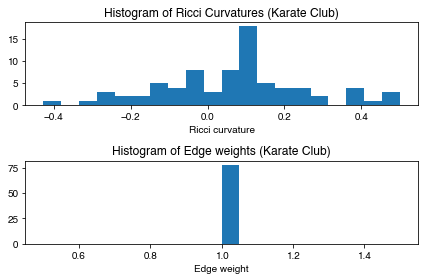

In [7]:
def show_results(G, curvature="ricciCurvature"):

    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (Karate Club)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (Karate Club)")

    plt.tight_layout()
    
show_results(G_orc)

### Forman-Ricci curvature
- To compute the Forman-Ricci curvature of a graph, we can use the class `FormanRicci` to load the graph and setup the parameter for the curvature computation.


In [8]:
frc = FormanRicci(G, verbose="TRACE")

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:Node weight not detected in graph, use "weight" as default node weight.


- As before, after setup the class `frc`, we can call `compute_ricci_curvature` to start the Ricci curvature computation.

In [9]:
frc.compute_ricci_curvature()
G_frc = frc.G.copy()  # save an intermediate result

Forman curvature (augmented) computation done.


- Notice that the Forman-Ricci curvature have different curvature distribution compare with Ollivier-Ricci curvature since they are defined from two different angles.
- Forman-Ricci curvature is not bounded. In this graph, the curvatures are ranged in [-20, 5].


Karate Club Graph, first 5 edges: 
Ricci curvature of edge (0,1) is 0.000000
Ricci curvature of edge (0,2) is -7.000000
Ricci curvature of edge (0,3) is -3.000000
Ricci curvature of edge (0,4) is -9.000000
Ricci curvature of edge (0,5) is -10.000000


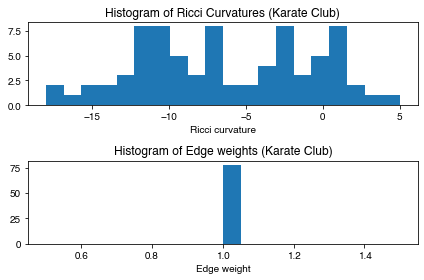

In [10]:
show_results(G_frc,curvature="formanCurvature")

## Ricci flow
- Ricci flow is an iterative process that aims to smooth out the curvatures of the input graph by adjusting the edges weight, it stretches edges of large negative Ricci curvature and shrinks edges of large positive Ricci curvature over time.
- To compute the Ollivier-Ricci flow, simply call function `compute_ricci_flow` to start the flow process. The iterations of flow is controlled by variable `iterations`.

In [11]:
# Start a Ricci flow with Lin-Yau's probability distribution setting with 4 process.
orf = OllivierRicci(G, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")

# Do Ricci flow for 2 iterations
orf.compute_ricci_flow(iterations=2)

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:No ricciCurvature detected, compute original_RC...
INFO:0.137217 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 0 === 
INFO:0.134418 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 1 === 
INFO:0.133285 secs for Ricci curvature computation.
INFO:0.437069 secs for Ricci flow computation.


- After "enough" Ricci flow iterations, the Ricci curvature of the graph will be converged to some value. In our experience, most of graphs need around 20~50 iterations.
- Now let's do more Ricci flow to flatten the Ricci curvature and refine the Ricci flow metric.

In [12]:
orf.set_verbose("ERROR") # mute logs
orf.compute_ricci_flow(iterations=50)
G_rf = orf.G.copy()

- After Ricci flow, the edge weights (Ricci flow metrics) changed and the edge Ricci curvatures are converged to $-0.0115$. 

Karate Club Graph, first 5 edges: 
Ricci curvature of edge (0,1) is -0.002814
Ricci curvature of edge (0,2) is -0.002783
Ricci curvature of edge (0,3) is -0.002808
Ricci curvature of edge (0,4) is -0.002823
Ricci curvature of edge (0,5) is -0.002830


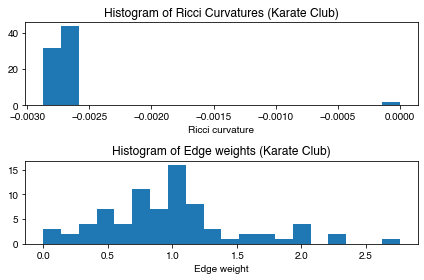

In [13]:
show_results(G_rf)

## Ricci flow for Community detection

In this section, we will show you how to use (Ollivier-) Ricci flow metric to detect community. If you wish to know how to use the build-in function directly, please jump to `Ricci community` section.

### Preliminary
#### Visualized the communities
- We can apply Ricci flow to detect communities in graph.
- To visualized the communities in graph, let's first draw the graph and color the nodes with its community.

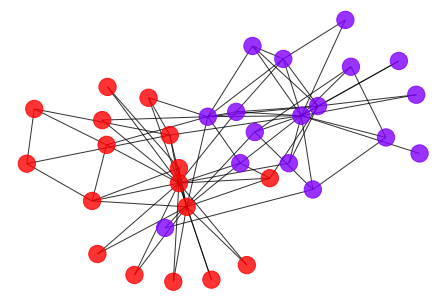

In [14]:
def draw_graph(G, clustering_label="club"):
    """
    A helper function to draw a nx graph with community.
    """
    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    node_color = le.fit_transform(list(complex_list.values()))

    nx.draw_spring(G, nodelist=G.nodes(),
                   node_color=node_color,
                   cmap=plt.cm.rainbow,
                   alpha=0.8)

draw_graph(G_rf)

#### Detect the communities
- To detect the communities of the graph, we can try a simple but effected method: **remove all edges with weight greater than a threshold**.
- By observing the histogram of edge weights, let's set the threshold to be 1.5 or 1.0, and apply modularity and Adjust Rand Index(ARI) as clustering metrics to evaluate the clustering result.
    - *Modularity*: A clustering metrics define **without ground-truth**.
    - *ARI*: A clustering metrics define **with ground-truth**.

In [15]:
def ARI(G, clustering, clustering_label="club"):
    """
    Computer the Adjust Rand Index (clustering accuracy) of "clustering" with "clustering_label" as ground truth.

    Parameters
    ----------
    G : NetworkX graph
        A given NetworkX graph with node attribute "clustering_label" as ground truth.
    clustering : dict or list or list of set
        Predicted community clustering.
    clustering_label : str
        Node attribute name for ground truth.

    Returns
    -------
    ari : float
        Adjust Rand Index for predicted community.
    """

    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true = le.fit_transform(list(complex_list.values()))

    if isinstance(clustering, dict):
        # python-louvain partition format
        y_pred = np.array([clustering[v] for v in complex_list.keys()])
    elif isinstance(clustering[0], set):
        # networkx partition format
        predict_dict = {c: idx for idx, comp in enumerate(clustering) for c in comp}
        y_pred = np.array([predict_dict[v] for v in complex_list.keys()])
    elif isinstance(clustering, list):
        # sklearn partition format
        y_pred = clustering
    else:
        return -1

    return metrics.adjusted_rand_score(y_true, y_pred)



def my_surgery(G_origin: nx.Graph(), weight="weight", cut=0):
    """A simple surgery function that remove the edges with weight above a threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: str
        The edge weight used as Ricci flow metric. (Default value = "weight")
    cut: float
        Manually assigned cutoff point.

    Returns
    -------
    G : NetworkX graph
        A graph after surgery.
    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    print("*************** Surgery time ****************")
    print("* Cut %d edges." % len(to_cut))
    G.remove_edges_from(to_cut)
    print("* Number of nodes now: %d" % G.number_of_nodes())
    print("* Number of edges now: %d" % G.number_of_edges())
    cc = list(nx.connected_components(G))
    print("* Modularity now: %f " % nx.algorithms.community.quality.modularity(G, cc))
    print("* ARI now: %f " % ARI(G, cc))
    print("*********************************************")

    return G

*************** Surgery time ****************
* Cut 12 edges.
* Number of nodes now: 34
* Number of edges now: 66
* Modularity now: 0.063117 
* ARI now: 0.072402 
*********************************************


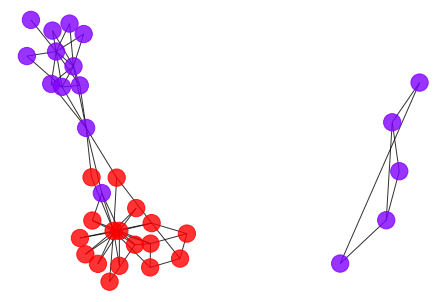

In [16]:
draw_graph(my_surgery(G_rf, cut=1.5))

*************** Surgery time ****************
* Cut 37 edges.
* Number of nodes now: 34
* Number of edges now: 41
* Modularity now: 0.687396 
* ARI now: 0.321943 
*********************************************


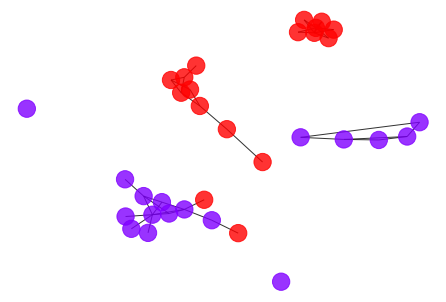

In [17]:
draw_graph(my_surgery(G_rf, cut=1.0))

- Both of the above cutoffs are not that promising. It seems to be a lot of works to find a good cutoff point, let's try to automize it by scan through the possible cutoff points and plot the corresponding accuracy.

In [18]:
def check_accuracy(G_origin, weight="weight", clustering_label="value", plot_cut=True):
    """To check the clustering quality while cut the edges with weight using different threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: float
        The edge weight used as Ricci flow metric. (Default value = "weight")
    clustering_label : str
        Node attribute name for ground truth.
    plot_cut: bool
        To plot the good guessed cut or not.

    """
    G = G_origin.copy()
    modularity, ari = [], []
    maxw = max(nx.get_edge_attributes(G, weight).values())
    cutoff_range = np.arange(maxw, 1, -0.025)

    for cutoff in cutoff_range:
        edge_trim_list = []
        for n1, n2 in G.edges():
            if G[n1][n2][weight] > cutoff:
                edge_trim_list.append((n1, n2))
        G.remove_edges_from(edge_trim_list)

        # Get connected component after cut as clustering
        clustering = {c: idx for idx, comp in enumerate(nx.connected_components(G)) for c in comp}

        # Compute modularity and ari
        modularity.append(community_louvain.modularity(clustering, G, weight))
        ari.append(ARI(G, clustering, clustering_label=clustering_label))

    plt.xlim(maxw, 0)
    plt.xlabel("Edge weight cutoff")
    plt.plot(cutoff_range, modularity, alpha=0.8)
    plt.plot(cutoff_range, ari, alpha=0.8)

    if plot_cut:
        good_cut = -1
        mod_last = modularity[-1]
        drop_threshold = 0.01  # at least drop this much to considered as a drop for good_cut
    
        # check drop from 1 -> maxw
        for i in range(len(modularity) - 1, 0, -1):
            mod_now = modularity[i]
            if mod_last > mod_now > 1e-4 and abs(mod_last - mod_now) / mod_last > drop_threshold:
                if good_cut != -1:
                    print("Other cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        cutoff_range[i + 1], mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
                else:
                    good_cut = cutoff_range[i + 1]
                    print("*Good Cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        good_cut, mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
            mod_last = mod_now

        plt.axvline(x=good_cut, color="red")
        plt.legend(['Modularity', 'Adjust Rand Index', 'Good cut'])
    else:
        plt.legend(['Modularity', 'Adjust Rand Index'])

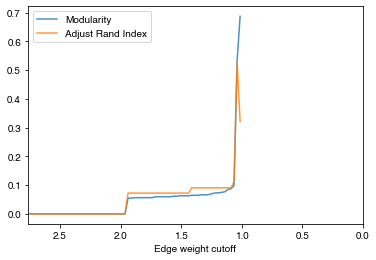

In [19]:
check_accuracy(G_rf,clustering_label="club",plot_cut=False)

- By the figure above, the best accuracy we can have is ~0.55 with ARI when cutoff set to ~1.05. Let's try to cut the graph with that weight:

*************** Surgery time ****************
* Cut 31 edges.
* Number of nodes now: 34
* Number of edges now: 47
* Modularity now: 0.104196 
* ARI now: 0.112884 
*********************************************


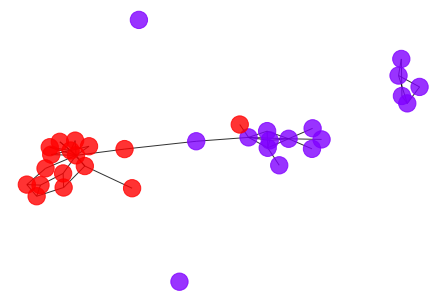

In [20]:
draw_graph(my_surgery(G_rf, cut=1.05))

- The result seems to be better, but it's still far from the optimal result, do we have some better way to fine-tune the community result?

### Optimal transportation and Communities
- The key of Ollivier-Ricci curvature is optimal transportation. The above example demonstrate the result of Ricci flow with Lin and Yau's setting of probability distribution for optimal transportation while uniformly distribute probabilities to neighbors. For node $x$ and it's neighbor set $\pi(x)$, they define the probability distribution with $\alpha\in[0,1]$ as the followings:
\begin{equation*}
m^{\alpha}_x(x_i)=
\begin{cases}
\alpha & \mbox{ if } x_i = x\\
\frac{1-\alpha}{|\pi(x)|} & \mbox{ if } x_i \in \pi(x)\\
0 & \mbox{ otherwise }
\end{cases}
\end{equation*}

- We proposed a more generalized setting of probability distributions as the following, where $C=\sum_{x_i \in \pi(x)} b^{-d(x,x_i)^p}$:

\begin{equation*}
m^{\alpha,p}_x(x_i)=
\begin{cases}
\alpha & \mbox{ if } x_i = x\\
\frac{1-\alpha}{C}\cdot  b^{-d(x,x_i)^p} & \mbox{ if } x_i \in \pi(x)\\
0 & \mbox{ otherwise }
\end{cases}
\end{equation*}

- This setting allows us to flavor the probability distribution by the edge weight and come with better result for community detection. If we take $p=0$, then the distribution fall back to Lin and Yau's setting, if we set $b=\exp$ and $p=2$, then this distribution is similar to "heat diffusion". It turns out that for most of the case, $(b,p)=(\exp,1)$ and $(b,p)=(\exp,2)$ performs the best for community detection task.


#### Parameters
**alpha**: The parameter for the probability distribution, range from [0 ~ 1]. It means the share of mass to leave on the original node. E.g. $x \rightarrow y$, alpha = 0.4 means 0.4 for $x$, 0.6 to evenly spread to $x$'s nbr. Default: `0.5`

**base**: Base variable for weight distribution. Default: `math.e`

**exp_power**: Exponential power for weight distribution. Default: `0`

**method**: Transportation method. ["OTD", "ATD", "Sinkhorn"]. Default: `Sinkhorn`

    - "OTD" for Optimal Transportation Distance.
    - "ATD" for Average Transportation Distance.
    - "Sinkhorn" for OTD approximated Sinkhorn distance (faster).


- Let's retry the karate club example with different settings:

In [21]:
orf2 = OllivierRicci(G, alpha=0.5, base=math.e, exp_power=1, verbose="ERROR")
orf2.compute_ricci_flow(iterations=50)
G_rf2 = orf2.G.copy()

Karate Club Graph, first 5 edges: 
Ricci curvature of edge (0,1) is -0.019349
Ricci curvature of edge (0,2) is -0.001516
Ricci curvature of edge (0,3) is -0.010322
Ricci curvature of edge (0,4) is -0.001809
Ricci curvature of edge (0,5) is -0.002310


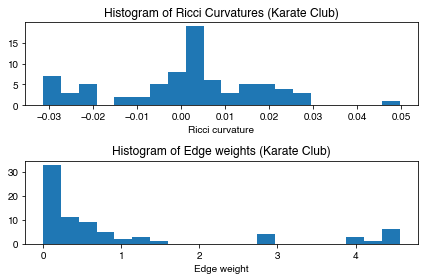

In [22]:
show_results(G_rf2)

*Good Cut:1.116173, diff:0.013329, mod_now:0.227998, mod_last:0.241327, ari:0.590553
Other cut:1.141173, diff:0.012329, mod_now:0.215669, mod_last:0.227998, ari:0.590553
Other cut:1.216173, diff:0.011743, mod_now:0.203926, mod_last:0.215669, ari:0.590553
Other cut:1.316173, diff:0.011320, mod_now:0.192605, mod_last:0.203926, ari:0.590553
Other cut:1.516173, diff:0.011600, mod_now:0.181005, mod_last:0.192605, ari:0.590553


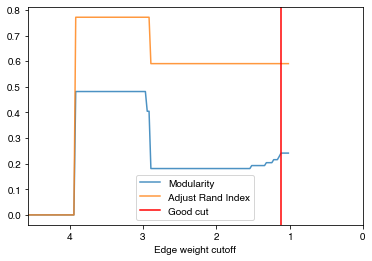

In [23]:
check_accuracy(G_rf2, clustering_label="club")

- The `check_accuracy` function above detects the possible good cut point by detecting the drop of the modularity from edge weight 1 -> max edge weight. Notice that in most of the case, the trend of ARI and modularity is similar in cutoff range grater than 1, this gives us a clue when community ground-truth is not available, we can always find the plateau of modularity curve and decide a cutoff point. 
- By `check_accuracy`, we acquired two cut points at 1.11 and 3.88, in most of the case, the smallest cut point is usually a good clustering, but it might cut the clustering too loose sometimes (because of the community hierarchy), so it's always a good idea to try different cut point to find the best result.
- Let's check the result with cut point 3.88 first, it yields a higher ARI with ~0.78, this is almost the **best result** we can get for the karate club graph for most of the community detection algorithm.

*************** Surgery time ****************
* Cut 10 edges.
* Number of nodes now: 34
* Number of edges now: 68
* Modularity now: 0.481650 
* ARI now: 0.771626 
*********************************************


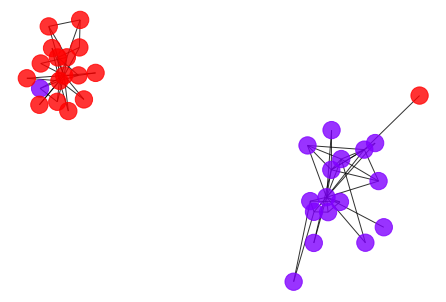

In [24]:
draw_graph(my_surgery(G_rf2, cut=3.88))

- Here is the result if we choose the second highest plateau (cut point 1.11) of the modularity curve as the cutoff point, we basically separate the community into a hierarchical clustering.

*************** Surgery time ****************
* Cut 19 edges.
* Number of nodes now: 34
* Number of edges now: 59
* Modularity now: 0.241327 
* ARI now: 0.590553 
*********************************************


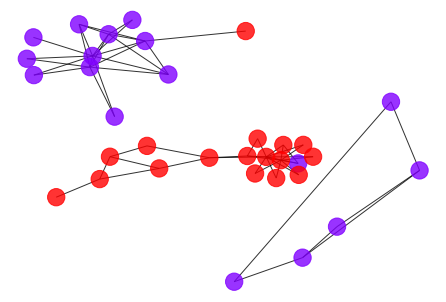

In [25]:
draw_graph(my_surgery(G_rf2, cut=1.11))

### Ricci community

Here let's demonstrate how to use the function `ricci_community` to automatically detect cutoff point and community.


#### General setting
- First, let us load the **football** graph that come with ground truth community from https://github.com/saibalmars/RicciFlow-SampleGraphs

In [26]:
from urllib.request import urlopen
from GraphRicciCurvature.util import cut_graph_by_cutoff

In [27]:
# Clean up the pre-computed Ricci curvature and Ricci flow to start from the begining.
def clean_graph(G):
    for n1, n2 in G.edges():
        del G[n1][n2]["ricciCurvature"]
        del G[n1][n2]["original_RC"]
        G[n1][n2]["weight"]=1
    for n in G.nodes():
        del G.nodes[n]["ricciCurvature"]

In [28]:
G_football_raw = nx.read_gexf(urlopen("https://raw.githubusercontent.com/saibalmars/RicciFlow-SampleGraphs/master/football_rf_sinkhorn_e2_20.gexf"))
G_football = G_football_raw.copy()

clean_graph(G_football)

- Since communities are detected using Ricci flow, let set up a *orc_football* class and do 5 iterations of Ricci flow.

In [29]:
orc_football = OllivierRicci(G_football,verbose="INFO")

In [30]:
orc_football.compute_ricci_flow(iterations=5)

INFO:No ricciCurvature detected, compute original_RC...
INFO:0.207077 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 0 === 
INFO:0.194240 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 1 === 
INFO:0.194005 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 2 === 
INFO:0.196292 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 3 === 
INFO:0.191516 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 4 === 
INFO:0.192682 secs for Ricci curvature computation.
INFO:1.321213 secs for Ricci flow computation.


- After Ricci flow computation, let's call `ricci_community` to detect the cutpoint and community clustering by the modularity detection method mentioned before. 
- The function will return a tuple of (cutpoint, dict_of_community).
- Since the football graph have a simpler community structure, the community clustering can be easily captured with just 10 iterations of Ricci flow. Notice that some more complex graph might take more iterations or even surgery to capture the clustering.

In [31]:
cc = orc_football.ricci_community()

INFO:Ricci flow detected, start cutting graph into community...
INFO:Communities detected: 11


- Let's draw the detected Ricci community.

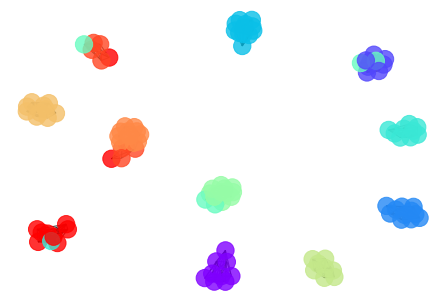

In [32]:
draw_graph(cut_graph_by_cutoff(orc_football.G,cutoff=cc[0]),clustering_label="value")

*Good Cut:1.983648, diff:0.049671, mod_now:0.794762, mod_last:0.844434, ari:0.846507
Other cut:2.133648, diff:0.025605, mod_now:0.756242, mod_last:0.781848, ari:0.691302
Other cut:2.158648, diff:0.008640, mod_now:0.747602, mod_last:0.756242, ari:0.612339
Other cut:2.208648, diff:0.087242, mod_now:0.677689, mod_last:0.764931, ari:0.507837
Other cut:2.258648, diff:0.006770, mod_now:0.665674, mod_last:0.672444, ari:0.361503
Other cut:2.533648, diff:0.249242, mod_now:0.449254, mod_last:0.698496, ari:0.336673
Other cut:2.558648, diff:0.007478, mod_now:0.441776, mod_last:0.449254, ari:0.128419


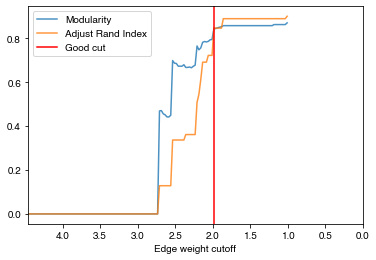

In [33]:
check_accuracy(orc_football.G,clustering_label="value")

#### Fine tuning
- Let's try `ricci_community` on a graph with less obvious community structure.

In [34]:
G_polbooks_raw = nx.read_gexf(urlopen("https://raw.githubusercontent.com/saibalmars/RicciFlow-SampleGraphs/master/polbooks_rf_sinkhorn_e2_20.gexf"))
G_polbooks = G_polbooks_raw.copy()

# Clean up the pre-computed Ricci curvature and Ricci flow to start from the begining. 
clean_graph(G_polbooks)

In [35]:
orc_polbooks = OllivierRicci(G_polbooks,verbose="INFO")

- So instead of call `compute_ricci_flow`, we could also call `ricci_community` directly, it will automatically compute Ricci flow with 10 iterations.

In [36]:
cc = orc_polbooks.ricci_community()

INFO:Ricci flow not detected yet, run Ricci flow with default setting first...
INFO:No ricciCurvature detected, compute original_RC...
INFO:0.201884 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 0 === 
INFO:0.193641 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 1 === 
INFO:0.191828 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 2 === 
INFO:0.188796 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 3 === 
INFO:0.191883 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 4 === 
INFO:0.191749 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 5 === 
INFO:0.195557 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 6 === 
INFO:0.195697 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 7 === 
INFO:0.194728 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 8 === 
INFO:0.198354 secs for Ricci curvature computation.
INF

- The community is less obvious, so with the good cut we can only get ARI with ~0.37

*Good Cut:1.475531, diff:0.012110, mod_now:0.468758, mod_last:0.480868, ari:0.464187
Other cut:1.675531, diff:0.006736, mod_now:0.452534, mod_last:0.459271, ari:0.464187
Other cut:2.325531, diff:0.009317, mod_now:0.507394, mod_last:0.516711, ari:0.519972
Other cut:2.625531, diff:0.005359, mod_now:0.504952, mod_last:0.510310, ari:0.604746
Other cut:3.550531, diff:0.007442, mod_now:0.501296, mod_last:0.508737, ari:0.664882
Other cut:3.950531, diff:0.009455, mod_now:0.480198, mod_last:0.489653, ari:0.674510
Other cut:4.050531, diff:0.006284, mod_now:0.473914, mod_last:0.480198, ari:0.674510


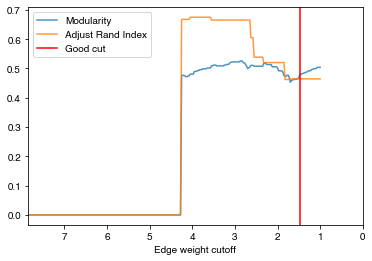

In [37]:
check_accuracy(orc_polbooks.G,clustering_label="value")

- For graph with weaker community structure, we suggest the followings to get the best community result:
    - Compute with more Ricci flow iterations: for some graph, it might take more iterations for Ricci flow to capture the community structure. For example, karate_club graph need 50+ iterations to capture the community structure.
    - Tuning the `exp_power`: bigger exp_power means we put more focus on neighbors with larger weights for optimal transportation, exp_power=0 means we treat every neighbors as equal. 

- There is currently no theoretical support to suggest what is the best setting, but we see some good results with 20 iterations and exp_power=2 for both synthetic and real-world graphs.

##### Tuning Ricci flow iterations
- Let's first try to do more iterations for this graph to see what we can get.
- You will see that the curve is somewhat compressed in the x direction.

In [38]:
orc_polbooks.set_verbose("ERROR")
orc_polbooks.compute_ricci_flow()

*Good Cut:1.261278, diff:0.132612, mod_now:0.380032, mod_last:0.512644, ari:0.365045
Other cut:1.311278, diff:0.011206, mod_now:0.368825, mod_last:0.380032, ari:0.464187
Other cut:1.386278, diff:0.011375, mod_now:0.357451, mod_last:0.368825, ari:0.464187
Other cut:1.411278, diff:0.010966, mod_now:0.346485, mod_last:0.357451, ari:0.464187
Other cut:1.436278, diff:0.010417, mod_now:0.336068, mod_last:0.346485, ari:0.464187
Other cut:1.561278, diff:0.011880, mod_now:0.437338, mod_last:0.449219, ari:0.462002
Other cut:1.586278, diff:0.011488, mod_now:0.425851, mod_last:0.437338, ari:0.462002
Other cut:1.636278, diff:0.032454, mod_now:0.393397, mod_last:0.425851, ari:0.462002
Other cut:1.661278, diff:0.009893, mod_now:0.383504, mod_last:0.393397, ari:0.462002
Other cut:1.686278, diff:0.027654, mod_now:0.355850, mod_last:0.383504, ari:0.462002
Other cut:1.711278, diff:0.016626, mod_now:0.339223, mod_last:0.355850, ari:0.462002
Other cut:1.736278, diff:0.015420, mod_now:0.323804, mod_last:0.3

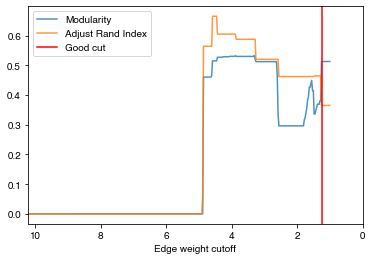

In [39]:
check_accuracy(orc_polbooks.G,clustering_label="value")

##### Tuning exp_power
- Let's try to use exp_power=1 to capture a better result. You can try other value to check the difference of ARI and modularity curve.


In [40]:
orc_polbooks1 = OllivierRicci(G_polbooks,exp_power=1,verbose="ERROR")
cc1 = orc_polbooks1.ricci_community()

*Good Cut:1.300639, diff:0.006430, mod_now:0.553931, mod_last:0.560361, ari:0.592280
Other cut:2.650639, diff:0.035449, mod_now:0.505359, mod_last:0.540808, ari:0.664882
Other cut:3.950639, diff:0.018714, mod_now:0.467233, mod_last:0.485947, ari:0.674510


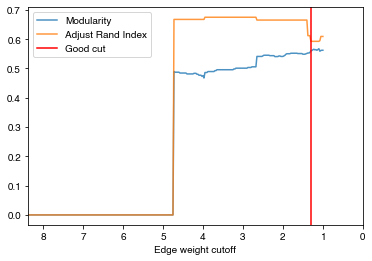

In [41]:
check_accuracy(orc_polbooks1.G,clustering_label="value")